In [259]:
# importing all required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest,mutual_info_classif,f_classif
from imblearn.over_sampling import SMOTE
import xgboost 
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
sb.set()

## Task 1 ( Prediction of confirmed COVID-19 cases among suspected cases)

In [260]:
ds = pd.read_excel('covid19_clinical_dataset.xlsx')
ds

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA and Data-preprocessing

In [261]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


In [262]:
ds.isnull().sum()

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
                                                         ... 
HCO3 (arterial blood gas analysis)                       5617
pO2 (arterial blood gas analysis)                        5617
Arteiral Fio2                                            5624
Phosphor                                                 5624
ctO2 (arterial blood gas analysis)                       5617
Length: 111, dtype: int64

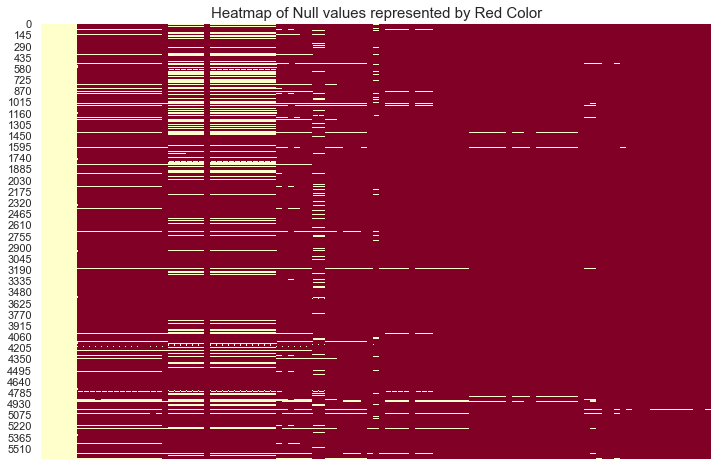

In [263]:
plt.figure(figsize=(12,8))
sb.heatmap(ds.isnull(),cbar=False, cmap = 'YlOrRd')
plt.title('Heatmap of Null values represented by Red Color', fontsize = 15)
plt.gca().set_xticks([])
plt.xticks([])
plt.show()

From above heatmap, we see that most of the columns are having huge number of null values. Therefore, we shall filter out those columns having null values less than 90 %.

In [264]:
# displaying columns having no null values.
for col in ds.columns:
    if ds[col].isnull().sum() == 0:
        print(col)

Patient ID
Patient age quantile
SARS-Cov-2 exam result
Patient addmited to regular ward (1=yes, 0=no)
Patient addmited to semi-intensive unit (1=yes, 0=no)
Patient addmited to intensive care unit (1=yes, 0=no)


In [265]:
# removing columns having missing values over 90%.
for col in ds.columns:
    if  ds[col].isnull().sum()/ds.shape[0] > 0.9:
        ds.drop(col,1,inplace = True)       

In [266]:
ds

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
# groupby columns for imputation of  missing values
groupby_list = ['Patient age quantile','SARS-Cov-2 exam result']

# imputing missing values for columns having 'float' dtype
for col in ds.select_dtypes(include = 'float64').columns:
    if ds[col].isnull().sum() > 0:
        ds[col] = ds.groupby(groupby_list)[col].transform(lambda x: x.fillna(x.mean()))

In [268]:
# imputing missing values for columns having 'object' dtype
for col in ds.select_dtypes(include = 'object').columns:
    if ds[col].isnull().sum() > 0:
        ds[col] = ds.groupby(['Patient age quantile'])[col].transform(lambda x: x.fillna(x.mode()[0]))

In [269]:
ds.isnull().sum()

Patient ID                                                0
Patient age quantile                                      0
SARS-Cov-2 exam result                                    0
Patient addmited to regular ward (1=yes, 0=no)            0
Patient addmited to semi-intensive unit (1=yes, 0=no)     0
Patient addmited to intensive care unit (1=yes, 0=no)     0
Hematocrit                                               18
Hemoglobin                                               18
Platelets                                                18
Mean platelet volume                                     18
Red blood Cells                                          18
Lymphocytes                                              18
Mean corpuscular hemoglobin concentration (MCHC)         18
Leukocytes                                               18
Basophils                                                18
Mean corpuscular hemoglobin (MCH)                        18
Eosinophils                             

In [270]:
# removing rows having further missing values after imputation
ds.dropna(inplace = True)

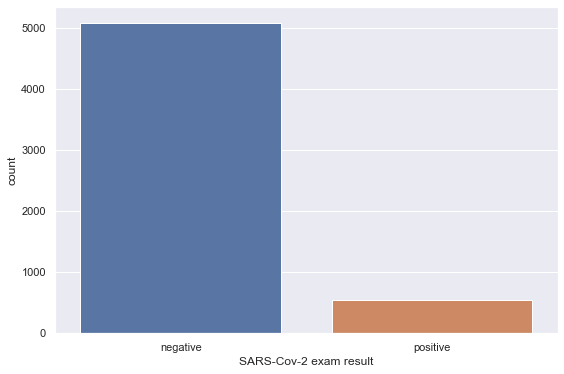

In [271]:
plt.figure(figsize = (9,6))
sb.countplot(x = 'SARS-Cov-2 exam result', data = ds)

From above data, we see that positive cases of Covid patients significantly less than that of negative, which implies heavy imbalance in our target class, so to account for this, we shall use Synthetic Minority Over-sampling Technique (SMOTE) before modelling. 

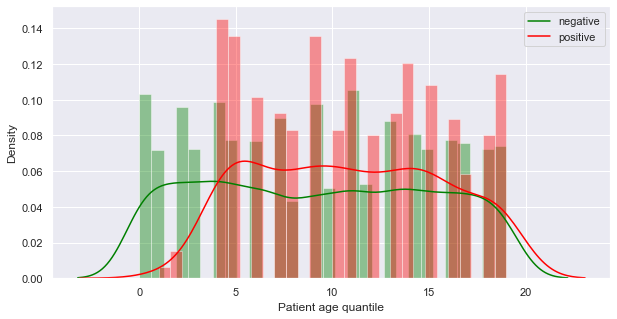

In [272]:
plt.figure(figsize = (10,5))
sb.distplot(ds['Patient age quantile'][ds['SARS-Cov-2 exam result'] == 'negative'], kde = True, bins = 30 , color = 'green')
sb.distplot(ds['Patient age quantile'][ds['SARS-Cov-2 exam result'] == 'positive'], kde = True, bins = 30, color = 'red')
plt.legend(['negative','positive'])
plt.show()

From above distribution plots, we can see that, risk of a patient to be COVID positive, increases for age quantile greater than 5.

In [273]:
ds['Patient addmited'] = ds['Patient addmited to regular ward (1=yes, 0=no)'] + ds['Patient addmited to semi-intensive unit (1=yes, 0=no)'].map({1:2,0:0}) + ds['Patient addmited to intensive care unit (1=yes, 0=no)'].map({1:3,0:0})

In [274]:
ds['Patient addmited'] = ds['Patient addmited'].map({0:'no admitted',1:'regular',2:'semi-intensive',3:'intensive'})

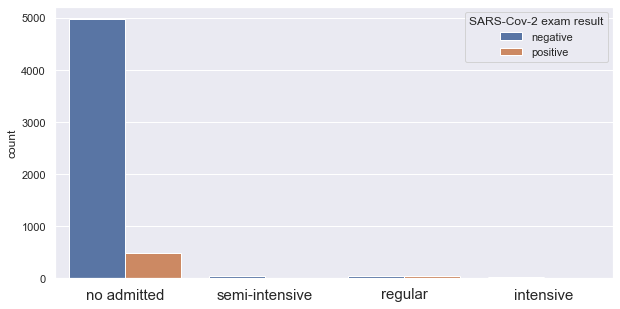

In [275]:
plt.figure(figsize = (10,5))
sb.countplot(x = 'Patient addmited', data = ds, hue = 'SARS-Cov-2 exam result')
plt.xlabel('')
plt.xticks(fontsize = 15)
plt.show()

From above plot, we see that majority of people are not admitted for proper care in treating the disease, which therefore, has the highest positive cases for this category, also if these patients are not treated properly, then it may lead to rapid spread of the disease.

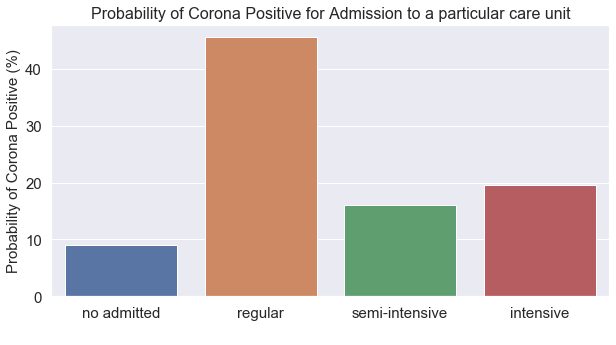

In [276]:
plt.figure(figsize = (10,5))
yes = ds[ds['SARS-Cov-2 exam result'] == 'negative']['Patient addmited'].value_counts()
no = ds[ds['SARS-Cov-2 exam result'] == 'positive']['Patient addmited'].value_counts()
df = pd.DataFrame([yes,no])
df.index = ['negative','positive']
df = df.T
df['prob%'] = (df['positive']/(df['negative'] + df['positive']))*100

sb.barplot(x = df.index, y = 'prob%', data = df, palette = 'deep')
plt.ylabel('Probability of Corona Positive (%)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel(' ' , fontsize = 15)
plt.yticks(fontsize = 15)
plt.title( 'Probability of Corona Positive for Admission to a particular care unit', fontsize = 16)
plt.show()

From above graphs, we see that patients who are admitted to regular ward for treatment, has higher chances of developing COVID positive than the other units. Assuming that the COVID results are after patients treatment on their respective units, then the above scenario may indicate that, semi-intensive and intensive care are effective in reducing the number of positive cases. Also, for patients who are not admitted, we see close to about 10% chances for them to develope the disease, which can be a potential factor for triggering the disease further. 

Text(0.5, 1, 'Heatmap of numeric medical data')

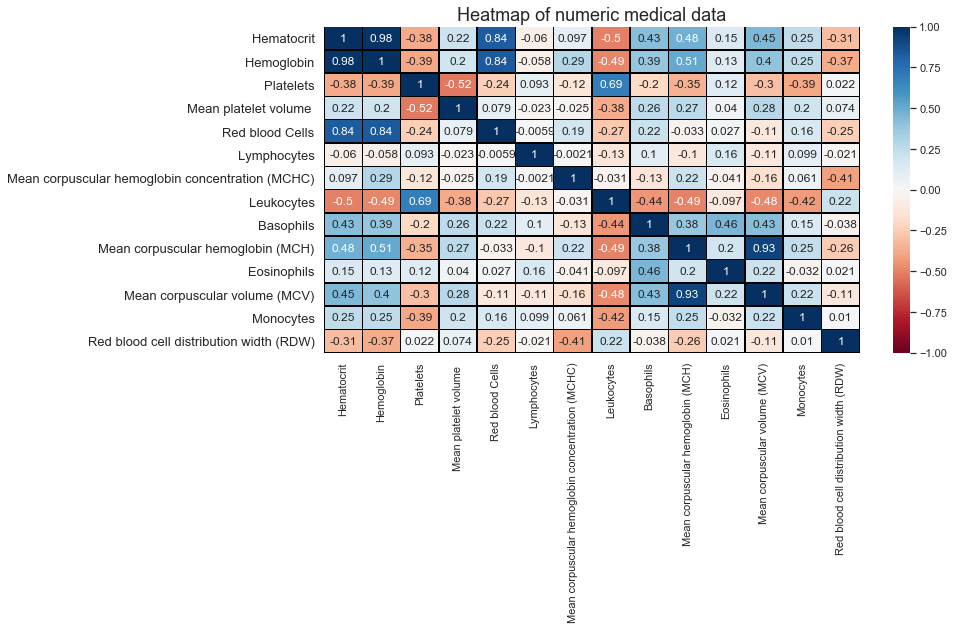

In [277]:
plt.figure(figsize = (12,6))
sb.heatmap(ds[list(ds.select_dtypes(include = 'float64').columns)].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.yticks(fontsize = 13)
plt.title('Heatmap of numeric medical data', fontsize = 18)

From above heatmap, we see few columns that are highly correlated to each other, particularly the column- Hematocrit and MCH, so we shall drop these columns, as we shall test linear models like logistic regression, that are usually sensitive to multicollinearity.

In [278]:
# removing highly correlated features
ds.drop(['Mean corpuscular hemoglobin (MCH)','Hematocrit'],1, inplace = True)

In [279]:
ds

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test",Patient addmited
0,44477f75e8169d2,13,negative,0,0,0,0.114514,0.233982,0.007724,0.134945,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
1,126e9dd13932f68,17,negative,0,0,0,-0.022340,-0.517413,0.010677,0.102004,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
2,a46b4402a0e5696,8,negative,0,0,0,0.176071,0.194423,-0.017372,0.182810,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
3,f7d619a94f97c45,5,negative,0,0,0,0.566626,0.089741,0.160267,0.527484,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
4,d9e41465789c2b5,15,negative,0,0,0,0.181872,0.089741,-0.197089,0.187544,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,21af7c93c7fc540,14,negative,0,0,0,0.225874,0.417959,-0.606387,0.027414,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5640,517c2834024f3ea,17,negative,0,0,0,0.219930,-0.137209,0.358475,0.115521,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5641,5c57d6037fe266d,4,negative,0,0,0,0.335031,0.076714,0.064695,0.218234,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5642,c20c44766f28291,10,negative,0,0,0,0.137433,-0.073981,-0.101517,0.013852,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted


In [280]:
# mapping target class to its numeric labels.
ds['SARS-Cov-2 exam result'] = ds['SARS-Cov-2 exam result'].map({'negative':0,'positive':1})

In [281]:
s = StratifiedKFold(n_splits = 10)

In [282]:
# here we are trying to find the optimum random state for Synthetic Minority Over-sampling Technique (SMOTE).
score_list = [] 
model  = LogisticRegression()
for r_state in np.arange(1,101,1):
        
        
        x_train, x_test, y_train, y_test = train_test_split(ds.drop(['SARS-Cov-2 exam result','Patient ID',
                                                                     'Patient addmited'], 1),
                                                            
                                                                     ds['SARS-Cov-2 exam result'],
                                                            
                                                                     test_size = 0.30, random_state = 42) 
        
         
        for col in   x_train.select_dtypes(include = ['object']).columns:
        

            encoder =  ce.TargetEncoder(cols = col)
            x_train[col] = encoder.fit_transform(x_train[col], y_train)
        

        x_train, y_train = SMOTE(sampling_strategy = 'minority', random_state = r_state).fit_sample(x_train,y_train)
        score = cross_val_score(model, x_train, y_train, cv = s, scoring = 'f1', n_jobs = -1 ).mean()
        score_list.append(score)

print('optimum score of :',max(score_list), ' correspounds to random state :', score_list.index(max(score_list))+1)

optimum_r_state =   score_list.index(max(score_list))+1  #selecting optimum random state

optimum score of : 0.9808262230095787  correspounds to random state : 38


In [283]:
# Here again, we are trying to tune the smoothing parameter using cross validation on training-set.
# for classification task.
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['SARS-Cov-2 exam result','Patient ID'], 1), 
                                                    ds['SARS-Cov-2 exam result'],
                                                    test_size = 0.30, random_state = 42)


score_list = []
smoothing_list = np.arange(0,5,.125)
model  =  LogisticRegression() # using LogisticRegression model for tuning smoothing parameter.
for num in smoothing_list:
    x_train_en = x_train.copy()
    
    for col in x_train.select_dtypes(include = ['object']).columns:
        

        encoder =  ce.TargetEncoder(cols = col, smoothing = num)
        x_train_en[col] = encoder.fit_transform(x_train_en[col], y_train)
        
        
    x_train_,y_train_= SMOTE(sampling_strategy = 'minority', random_state = optimum_r_state).fit_sample(x_train_en, y_train)
       
        
        
    score = cross_val_score(model, x_train_ , y_train_, cv = s, scoring = 'f1', n_jobs = -1 ).mean()
    score_list.append(score)
        
print('Optimum cross-val-score:',max(score_list),
      'corresponds to smoothing value of:',smoothing_list[score_list.index(max(score_list))])

optimum_smoothing = smoothing_list[score_list.index(max(score_list))] # selecting optimum smoothing parameter

Optimum cross-val-score: 0.9812552431725576 corresponds to smoothing value of: 2.25


In [284]:
 # train-test split
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['SARS-Cov-2 exam result','Patient ID'], 1), 
                                                    ds['SARS-Cov-2 exam result'],
                                                    test_size = 0.30, random_state = 42) 

In [285]:
# target/mean encoding categorical variables
for col in  x_train.select_dtypes(include = ['object']).columns:
            encoder =  ce.TargetEncoder(cols = col, smoothing = optimum_smoothing)
            x_train[col] = encoder.fit_transform(x_train[col], y_train)
            x_test[col] = encoder.transform(x_test[col])

In [286]:
x_train

,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),...,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test",Patient addmited
2763,3,0,0,0,-0.442504,0.177181,0.076672,-0.413425,-0.086513,0.296866,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
5482,3,0,0,0,-0.442504,0.177181,0.076672,-0.413425,-0.086513,0.296866,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
3812,7,0,0,0,-0.027788,0.264150,-0.203954,-0.024474,0.431097,-0.405274,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
3866,14,0,0,0,0.583334,-0.543932,0.284926,0.470283,-0.063546,0.310533,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
706,18,0,0,0,-0.093081,-0.114625,0.216967,-0.134584,-0.004362,0.167056,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,12,0,0,0,0.980156,-0.605346,0.908221,1.071674,0.906870,0.343725,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
5203,0,0,0,0,-1.159430,0.702944,-0.529513,-0.491551,0.494317,-0.102531,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
5238,9,0,0,0,-0.025553,0.011471,0.004923,-0.099615,0.132695,-0.023947,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
5405,11,0,0,0,0.284166,-0.187411,0.128934,0.225893,-0.059217,0.203779,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647


In [287]:
# using SMOTE for treating data imbalance
smote = SMOTE(sampling_strategy = 'minority',random_state = optimum_r_state)
x_train, y_train = smote.fit_sample(x_train,y_train)

In [288]:
y_train.value_counts()

1    3552
0    3552
Name: SARS-Cov-2 exam result, dtype: int64

In [289]:
x_train

,Patient age quantile,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),...,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test",Patient addmited
0,3,0,0,0,-0.442504,0.177181,0.076672,-0.413425,-0.086513,0.296866,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
1,3,0,0,0,-0.442504,0.177181,0.076672,-0.413425,-0.086513,0.296866,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
2,7,0,0,0,-0.027788,0.264150,-0.203954,-0.024474,0.431097,-0.405274,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
3,14,0,0,0,0.583334,-0.543932,0.284926,0.470283,-0.063546,0.310533,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
4,18,0,0,0,-0.093081,-0.114625,0.216967,-0.134584,-0.004362,0.167056,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7099,7,0,0,0,0.625105,-0.525788,0.010676,0.495749,-0.668160,0.642460,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
7100,11,0,0,0,0.057442,-0.506269,-0.647630,-0.335614,-1.256687,1.765891,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.226664
7101,12,0,0,0,0.471076,-0.710551,0.052749,0.628711,0.343953,0.007651,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647
7102,7,0,0,0,0.625105,-0.525788,0.010676,0.495749,-0.668160,0.642460,...,0.098319,0.097939,0.098194,0.099742,0.098019,0.098219,0.098019,0.098566,0.098974,0.090647


In [290]:
# feature selection using SelectKBest
selector = SelectKBest(f_classif)
selector.fit(x_train, y_train)

SelectKBest()

Text(0, 0.5, 'Feature importance score')

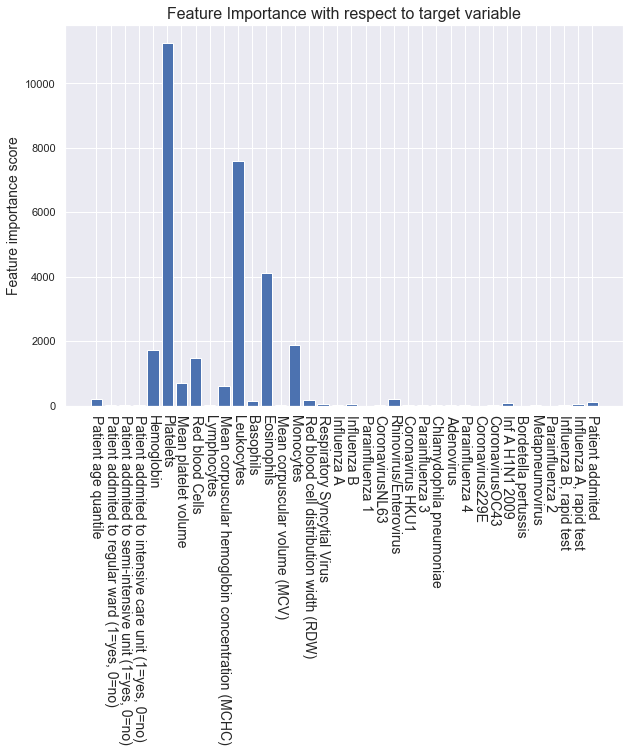

In [291]:
# plotting  the scores
plt.figure(figsize = (10,7))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 14)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)

In [292]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
5,Platelets,11248.053848
10,Leukocytes,7598.876498
12,Eosinophils,4108.340504
14,Monocytes,1871.540659
4,Hemoglobin,1715.229395
7,Red blood Cells,1486.123600
6,Mean platelet volume,689.407954
9,Mean corpuscular hemoglobin concentration (MCHC),598.853205
21,Rhinovirus/Enterovirus,214.692072
0,Patient age quantile,191.639796


In [293]:
# keeping features with scores above threshold score.
threshold = 0
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
5,Platelets,11248.053848
10,Leukocytes,7598.876498
12,Eosinophils,4108.340504
14,Monocytes,1871.540659
4,Hemoglobin,1715.229395
7,Red blood Cells,1486.123600
6,Mean platelet volume,689.407954
9,Mean corpuscular hemoglobin concentration (MCHC),598.853205
21,Rhinovirus/Enterovirus,214.692072
0,Patient age quantile,191.639796


In [294]:
print('no. of selected features:', len(selected_features))

no. of selected features: 34


In [295]:
# selecting feaures scoring above threshold for train and test set.
x_train = x_train[list(selected_features['Feature'])]
x_test = x_test[list(selected_features['Feature'])]

In [296]:
x_train.shape, x_test.shape

((7104, 34), (1688, 34))

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.9940958531299874
score_std: 0.004223310283784024
----------
model: LogisticRegression()
CV score:0.9809813476694206
score_std: 0.0047181815216914514
----------
model: SVC()
CV score:0.9829331526968259
score_std: 0.005389997306206789
----------
model: AdaBoostClassifier()
CV score:0.9852992883993478
score_std: 0.012630576140904626
----------
model: GradientBoostingClassifier()
CV score:0.9886104020314495
score_std: 0.0077394078082395
----------
model: KNeighborsClassifier()
CV score:0.9842145088603728
score_std: 0.003565989012460649
----------
model: XGBClassifier()
CV score:0.989479626455099
score_std: 0.005765073230260935
----------
model: DecisionTreeClassifier()
CV score:0.9861418961574347
score_std: 0.01192753214509105
----------
model: GaussianNB()
CV score:0.6973636566307166
score_std: 0.008166023708279463
----------


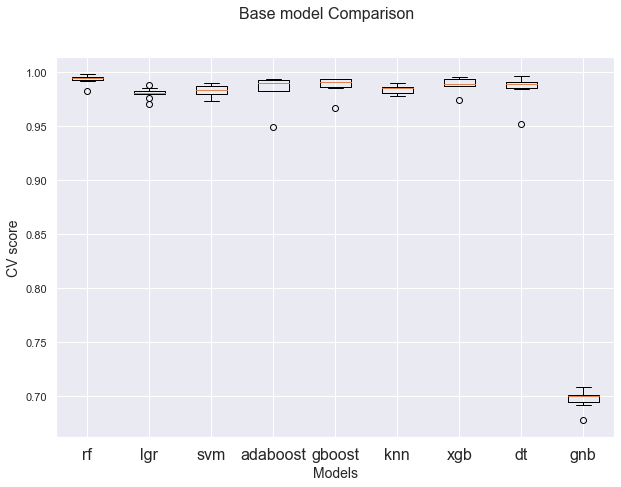

In [297]:
# initializing each model
rf = RandomForestClassifier()
svm = SVC()
lgr = LogisticRegression()
adaboost =  AdaBoostClassifier()
gboost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = xgboost.XGBClassifier()
dt = DecisionTreeClassifier()
gnb = GaussianNB()

models = [rf, lgr, svm, adaboost, gboost, knn, xgb, dt, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = s , scoring = 'f1', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','dt','gnb'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(10,7)
plt.show() 

Based on above cross-val-scores, we shall select models- rf, gboost, xgb and dt for further tuning.

### Hyper-parameter tuning

In [298]:
# initializing model parameters
param_gboost =  dict(
   learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5, 0.6 ],
   max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
   n_estimators = [30 ,50,75,100, 150, 200],
   min_samples_split = [1,2,3],
   min_samples_leaf = [1,2], random_state =  [40,41,42,43,44])

param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ], alpha = [0.05,0.1,0.5,0.75,1,1.75,2],
                 reg_lambda = [0.05,0.1,0.5,0.75,1,1.75,2])


param_rf = dict(n_estimators = [10,15,20,25,30], criterion = ['gini', 'entropy'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44], class_weight = ['balanced'])

param_dt = dict(splitter = ['best', 'random'], criterion = ['gini', 'entropy'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44],
                class_weight = ['balanced'])

In [299]:
model_param_list = [ (xgb, param_xgb), (gboost, param_gboost), (rf, param_rf), (dt, param_dt)]

In [300]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = s, n_jobs = -1, scoring = 'f1',
                                  random_state = 42)
    r_search.fit( x_train, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: XGBClassifier()
best_cvscore: 0.9926776289019121
best_param: {'reg_lambda': 0.75, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.4, 'alpha': 0.75}


model: GradientBoostingClassifier()
best_cvscore: 0.9922859489013363
best_param: {'random_state': 44, 'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.6}


model: RandomForestClassifier()
best_cvscore: 0.9917305177116995
best_param: {'random_state': 40, 'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini', 'class_weight': 'balanced'}


model: DecisionTreeClassifier()
best_cvscore: 0.9873491601226286
best_param: {'splitter': 'best', 'random_state': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced'}


best_estimators: [XGBClassifier(alpha=0.75, colsample_bytree=0.4, gamma=0.3, learning_rate=0.2,
              max_dep

### Testing

In [301]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('model',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_train,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_train,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model XGBClassifier(alpha=0.75, colsample_bytree=0.4, gamma=0.3, learning_rate=0.2,
              max_depth=6, min_child_weight=3, reg_lambda=0.75) 

accuracy: 100.0 % 

f1_score: 100.0 % 

auc_roc_score: 100.0 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3552
           1       1.00      1.00      1.00      3552

    accuracy                           1.00      7104
   macro avg       1.00      1.00      1.00      7104
weighted avg       1.00      1.00      1.00      7104

------------------------------------------------------------------------------


model GradientBoostingClassifier(learning_rate=0.6, max_depth=5, min_samples_split=3,
                           n_estimators=150, random_state=44) 

accuracy: 100.0 % 

f1_score: 100.0 % 

auc_roc_score: 100.0 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00    

In [302]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_test,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: XGBClassifier(alpha=0.75, colsample_bytree=0.4, gamma=0.3, learning_rate=0.2,
              max_depth=6, min_child_weight=3, reg_lambda=0.75) 

accuracy: 99.05 % 

f1_score: 94.84 % 

auc_roc_score: 97.43 % 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1534
           1       0.94      0.95      0.95       154

    accuracy                           0.99      1688
   macro avg       0.97      0.97      0.97      1688
weighted avg       0.99      0.99      0.99      1688

------------------------------------------------------------------------------


Model: GradientBoostingClassifier(learning_rate=0.6, max_depth=5, min_samples_split=3,
                           n_estimators=150, random_state=44) 

accuracy: 98.82 % 

f1_score: 93.59 % 

auc_roc_score: 97.01 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.99  

From  above train and test results, XGBoost model scored the highest across all metrics, particularly on the test set, hence, giving us confidence in selecting it as our classifier for this task.

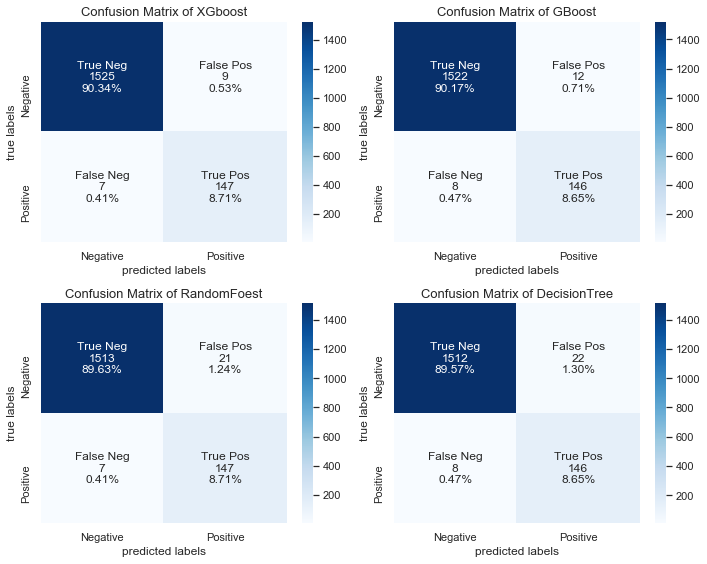

In [303]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3]
model = ['XGboost','GBoost','RandomFoest','DecisionTree']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(2,2, index + 1 )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)
    groups = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groups,group_counts,group_percent)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['Negative','Positive'])
    ax.set_yticklabels(['Negative','Positive'])
    fig.set_size_inches(10, 8)
    plt.tight_layout()
plt.show()

By analysing the above heatmap, we see that both XGBoost and Random Forest models, has lowest 'Type-II' error, which is very important, as because if this error will be high, then positive cases will be classified as negative cases (which will increase the risk of further spread of the disease), and it also has highest True Positives, which is very crucial in identifying the positive cases. But the XGBoost also has the advantage over other models, as it lowest 'Type-I' error, which makes it a better overall for predicting the Covid cases for this task. 

In [170]:
# selecting best model as XGBClassifier.
selected_model_1 = best_estimator_list[0]
selected_model_1.fit(x_train, y_train)
y_pred = selected_model_1.predict(x_test)

Text(0.5, 1.0, 'Feature Importance')

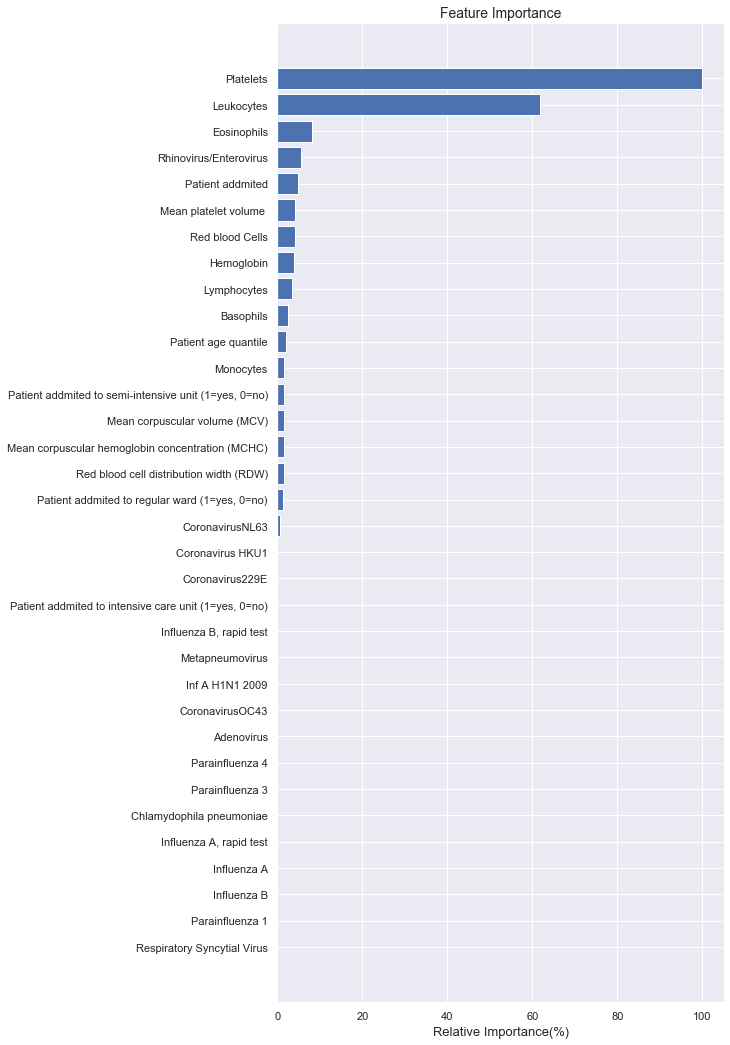

In [172]:
feature_importance = selected_model_1.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
yl = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8, 18))
plt.barh(yl, feature_importance[sorted_idx], align='center')
plt.yticks(yl, x_train.keys()[sorted_idx])
plt.xlabel('Relative Importance(%)',fontsize = 13)
plt.title('Feature Importance',fontsize = 14)

From selected model's  Feature importance plot, we see that Platelates and Leukocytes  count has significant importance in predicting COVID cases.

In [173]:
test_df = pd.DataFrame({'Actual':y_test.values,'Predicted':y_pred})

In [174]:
test_df.to_csv('covid_cases_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [175]:
# Saving the final model as XGBClassifier.
import joblib

joblib.dump(selected_model_1, 'covid_cases_pred.obj')
print('Model successfully saved.')

Model successfully saved.


## Task 2 (Prediction of  admission to general ward, semi-intensive unit or intensive care unit among confirmed COVID-19 cases.)

In [51]:
ds

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test",Patient addmited
0,44477f75e8169d2,13,0,0,0,0,0.114514,0.233982,0.007724,0.134945,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
1,126e9dd13932f68,17,0,0,0,0,-0.022340,-0.517413,0.010677,0.102004,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
2,a46b4402a0e5696,8,0,0,0,0,0.176071,0.194423,-0.017372,0.182810,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
3,f7d619a94f97c45,5,0,0,0,0,0.566626,0.089741,0.160267,0.527484,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
4,d9e41465789c2b5,15,0,0,0,0,0.181872,0.089741,-0.197089,0.187544,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,21af7c93c7fc540,14,0,0,0,0,0.225874,0.417959,-0.606387,0.027414,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5640,517c2834024f3ea,17,0,0,0,0,0.219930,-0.137209,0.358475,0.115521,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5641,5c57d6037fe266d,4,0,0,0,0,0.335031,0.076714,0.064695,0.218234,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5642,c20c44766f28291,10,0,0,0,0,0.137433,-0.073981,-0.101517,0.013852,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted


In [52]:
# droping target features, that have already been extracted
ds.drop(list(ds.columns)[3:6], 1, inplace = True)

In [53]:
ds

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test",Patient addmited
0,44477f75e8169d2,13,0,0.114514,0.233982,0.007724,0.134945,-0.146467,-0.308772,0.226509,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
1,126e9dd13932f68,17,0,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
2,a46b4402a0e5696,8,0,0.176071,0.194423,-0.017372,0.182810,0.221703,0.260745,0.100649,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
3,f7d619a94f97c45,5,0,0.566626,0.089741,0.160267,0.527484,0.096611,0.210956,0.200737,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
4,d9e41465789c2b5,15,0,0.181872,0.089741,-0.197089,0.187544,-0.097662,-0.061962,-0.034213,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,21af7c93c7fc540,14,0,0.225874,0.417959,-0.606387,0.027414,0.124822,0.205849,0.154557,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5640,517c2834024f3ea,17,0,0.219930,-0.137209,0.358475,0.115521,-0.023080,-0.333405,-0.101475,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5641,5c57d6037fe266d,4,0,0.335031,0.076714,0.064695,0.218234,0.209383,0.380608,-0.033183,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted
5642,c20c44766f28291,10,0,0.137433,-0.073981,-0.101517,0.013852,0.114095,-0.228848,-0.349236,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative,no admitted


In [54]:
# value count of targey variable 
ds['Patient addmited'].value_counts()

no admitted       5456
regular             79
semi-intensive      50
intensive           41
Name: Patient addmited, dtype: int64

Here we see that, target varible is imbalanced, so we shall use SMOTE techique.

In [55]:
# mapping target classes to its numeric labels
ds['Patient addmited'] = ds['Patient addmited'].map({'no admitted':0,'regular':1,'semi-intensive':2,'intensive':3})

In [56]:
# here we are trying to find the optimum random state for Synthetic Minority Over-sampling Technique (SMOTE).
score_list = [] 
model  = LogisticRegression()
for r_state in np.arange(1,101,1):
        
        
        x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Patient addmited','Patient ID'], 1), 
                                                    ds['Patient addmited'],
                                                    test_size = 0.30, random_state = 42) 
        
         
        for col in   x_train.select_dtypes(include = ['object']).columns:
        

            encoder =  ce.TargetEncoder(cols = col)
            x_train[col] = encoder.fit_transform(x_train[col], y_train)
        

        x_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = r_state).fit_sample(x_train,y_train)
        score = cross_val_score(model, x_train, y_train, cv = s, scoring = 'f1_weighted', n_jobs = -1 ).mean()
        score_list.append(score)

print('optimum score of :',max(score_list), ' correspounds to random state :', score_list.index(max(score_list))+1)

optimum_r_state =   score_list.index(max(score_list))+1  #selecting optimum random state

optimum score of : 0.6232579333865615  correspounds to random state : 69


In [57]:
# Here again, we are trying to tune the smoothing parameter using cross validation on training-set.
# for classification task.
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Patient addmited','Patient ID'], 1), 
                                                    ds['Patient addmited'],
                                                    test_size = 0.30, random_state = 42)


score_list = []
smoothing_list = np.arange(0,5,.125)
model  = LogisticRegression() # using LogisticRegression model for tuning smoothing parameter.
for num in smoothing_list:
    x_train_en = x_train.copy()
    
    for col in x_train.select_dtypes(include = ['object']).columns:
        

        encoder =  ce.TargetEncoder(cols = col, smoothing = num)
        x_train_en[col] = encoder.fit_transform(x_train_en[col], y_train)
        
        
    x_train_, y_train_ = SMOTE(sampling_strategy = 'auto', random_state = 69).fit_sample(x_train_en, y_train)
       
        
        
    score = cross_val_score(model, x_train_ , y_train_, cv = s, scoring = 'f1_weighted', n_jobs = -1 ).mean()
    score_list.append(score)
        
print('Optimum cross-val-score:',max(score_list),
      'corresponds to smoothing value of:',smoothing_list[score_list.index(max(score_list))]) 

optimum_smoothing = smoothing_list[score_list.index(max(score_list))] # selecting optimum smoothing parameter

Optimum cross-val-score: 0.626908546232029 corresponds to smoothing value of: 3.125


In [58]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Patient addmited','Patient ID'], 1), 
                                                    ds['Patient addmited'],
                                                    test_size = 0.30, random_state = 42)


In [59]:
# target/mean encoding categorical variables
for col in  x_train.select_dtypes(include = ['object']).columns:
            encoder =  ce.TargetEncoder(cols = col, smoothing = optimum_smoothing)
            x_train[col] = encoder.fit_transform(x_train[col], y_train)
            x_test[col] = encoder.transform(x_test[col])

In [60]:
# using SMOTE for treating data imbalance
smote = SMOTE(sampling_strategy = 'auto',random_state = optimum_r_state)
x_train, y_train = smote.fit_sample(x_train,y_train)

In [61]:
y_train.value_counts()

3    3817
2    3817
1    3817
0    3817
Name: Patient addmited, dtype: int64

In [62]:
# feature selection using SelectKBest
selector = SelectKBest(f_classif)
selector.fit(x_train, y_train)

SelectKBest()

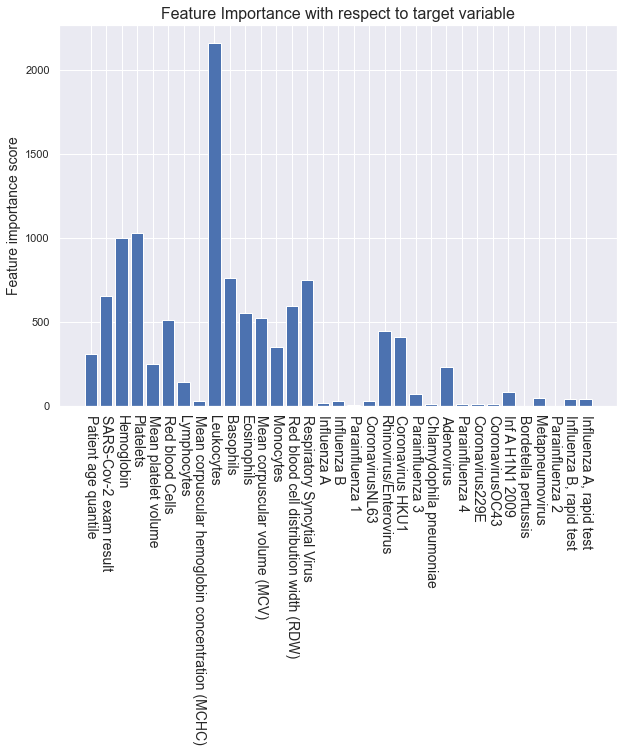

In [63]:
# plotting  the scores
plt.figure(figsize = (10,7))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 14)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

In [64]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
8,Leukocytes,2160.491077
3,Platelets,1026.359797
2,Hemoglobin,996.800911
9,Basophils,759.197527
14,Respiratory Syncytial Virus,749.335838
1,SARS-Cov-2 exam result,655.340202
13,Red blood cell distribution width (RDW),594.910593
10,Eosinophils,553.199555
11,Mean corpuscular volume (MCV),524.412431
5,Red blood Cells,507.202165


In [65]:
# keeping features with scores above threshold score.
threshold = 0
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
8,Leukocytes,2160.491077
3,Platelets,1026.359797
2,Hemoglobin,996.800911
9,Basophils,759.197527
14,Respiratory Syncytial Virus,749.335838
1,SARS-Cov-2 exam result,655.340202
13,Red blood cell distribution width (RDW),594.910593
10,Eosinophils,553.199555
11,Mean corpuscular volume (MCV),524.412431
5,Red blood Cells,507.202165


In [66]:
print('no. of selected features:', len(selected_features))

no. of selected features: 31


In [67]:
# selecting feaures scoring above threshold for train and test set.
x_train = x_train[list(selected_features['Feature'])]
x_test = x_test[list(selected_features['Feature'])]

In [68]:
x_train.shape, x_test.shape

((15268, 31), (1688, 31))

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.9388273441170633
score_std: 0.008102376871782087
----------
model: LogisticRegression()
CV score:0.6250469849103261
score_std: 0.00963227245010672
----------
model: SVC()
CV score:0.7792363093910047
score_std: 0.013246644628911132
----------
model: AdaBoostClassifier()
CV score:0.6750550363897869
score_std: 0.027471132346160304
----------
model: GradientBoostingClassifier()
CV score:0.9146245726943242
score_std: 0.009767767673173288
----------
model: KNeighborsClassifier()
CV score:0.9170049482760227
score_std: 0.005558697872439276
----------
model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100,

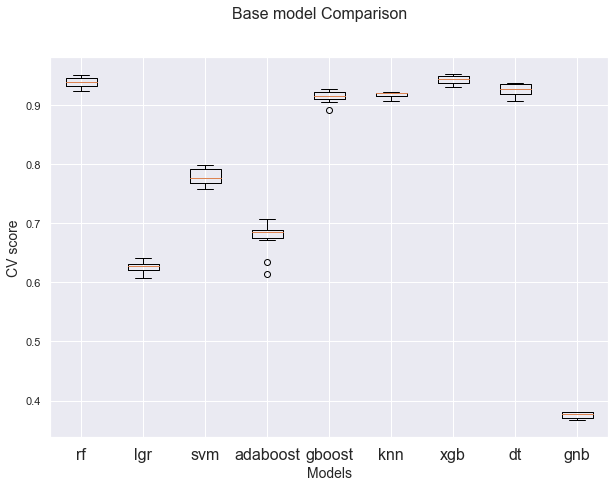

In [69]:
rf = RandomForestClassifier()
svm = SVC()
lgr = LogisticRegression()
adaboost =  AdaBoostClassifier()
gboost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = xgboost.XGBClassifier()
dt = DecisionTreeClassifier()
gnb = GaussianNB()

models = [rf, lgr, svm, adaboost, gboost, knn, xgb, dt, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = s , scoring = 'f1_weighted', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','dt','gnb'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(10,7)
plt.show() 

Based on the above cross-val-scores, we shall choose the top 3 models,i.e. rf, gboost, xgb and dt.

In [86]:
model_param_list = [ (xgb, param_xgb), (rf, param_rf) , (dt,param_dt)]

### Hyper-parameter tuning

In [87]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = s, n_jobs = -1, scoring = 'f1_weighted',
                                  random_state = 42)
    r_search.fit( x_train, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
best_cvscore: 0.9460944580339765
best_param: {'reg_lambda': 2, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7, 'alpha': 0.1}


model: RandomForestClassifier()
best_cvscore: 0.9385186484593897
best_param: {'random_state': 42, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': Non

### Testing

In [88]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('model',model)
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_train,y_pred, average = 'weighted')*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.100000001,
              reg_lambda=2, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
accuracy: 96.85 % 

f1_score: 96.87 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3817
           1       0.99      0.96      0.97      3817
           2       0.99      0.94      0.96      3817
           3       0.91      0.99    

In [89]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred, average = 'weighted')*100,2),'%','\n')
    print('confusion_matrix:','\n',confusion_matrix(y_test,y_pred),'\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.100000001,
              reg_lambda=2, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 

accuracy: 95.44 % 

f1_score: 95.75 % 

confusion_matrix: 
 [[1600   23    5   11]
 [  14    5    1    2]
 [   6    4    2    3]
 [   5    1    2    4]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1639
           1       0.15    

From above test results, we see XGBoost performed the best in terms of f1 score and accuracy. Let us
visualize the respective heatmaps to get the complete picture of the test result.

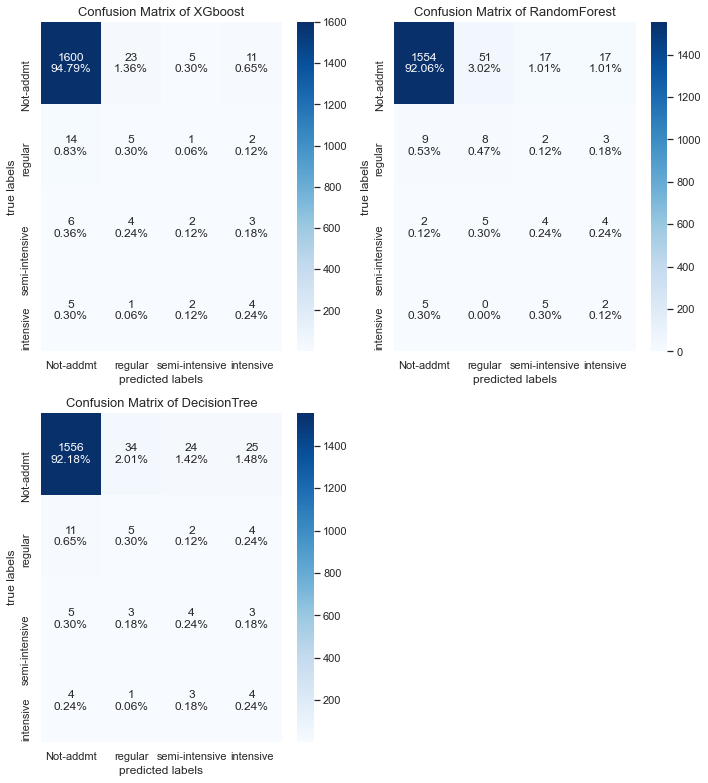

In [90]:
# visualizing confusion matrix with the help of heatmaps.
model_index = [0,1,2]
model = ['XGboost','RandomForest','DecisionTree']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(3,2, index + 1 )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)

    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percent)]
    labels = np.asarray(labels).reshape(4,4)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    ax.set_xticklabels(['Not-addmt','regular','semi-intensive','intensive'])
    ax.set_yticklabels(['Not-addmt','regular','semi-intensive','intensive'])
    fig.set_size_inches(10, 16)
    plt.tight_layout()
plt.show()

Although XGBoost performed the best interms of accuracy and f1 score, but RandomForest seemed to performed well by its ability to classify the regular ward and semi-intensive unit, compared to other models, particularly the regular ward, which early on showed that patients addmited to  regular wards have highest probability of COVID positive cases. Hence, we shall choose our classifier as RandomForest in this task.

In [93]:
# selecting best model as RandomForestClassifier.
selected_model_2 =   RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=3, n_estimators=25, random_state=42) 


selected_model_2.fit(x_train, y_train)
y_pred = selected_model_2.predict(x_test)

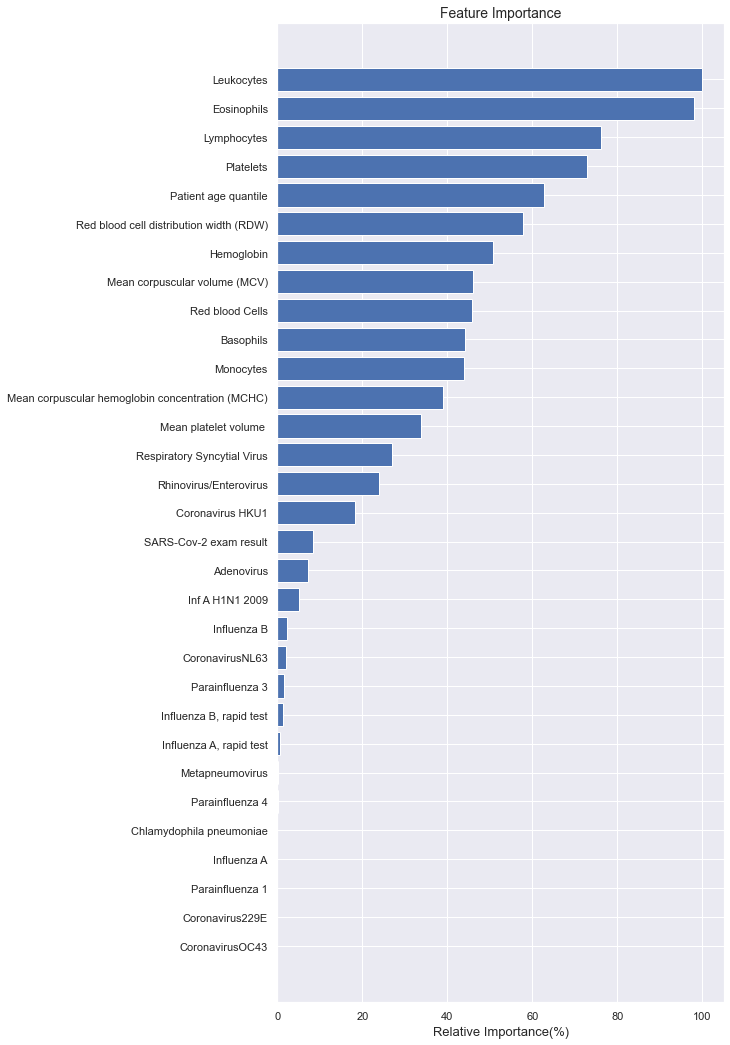

In [94]:
feature_importance = selected_model_2.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
yl = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8, 18))
plt.barh(yl, feature_importance[sorted_idx], align='center')
plt.yticks(yl, x_train.keys()[sorted_idx])
plt.xlabel('Relative Importance(%)',fontsize = 13)
plt.title('Feature Importance',fontsize = 14)
plt.show()

From above feature importance plot for the selected model, we see medical data such as Leukocytes, Eosinophils, Lymphocytes are top 3 features for prediction of the target variables, also, these features have shown importance in contributing in predicting COVID cases in task 1 as well. 

In [77]:
test_df = pd.DataFrame({'Actual':y_test.values,'Predicted':y_pred})

In [78]:
test_df.to_csv('covid_unit_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [79]:
# Saving the final model as RandomForestClassifier.
import joblib

joblib.dump(selected_model_2, 'covid_unit_pred.obj')
print('Model successfully saved.')

Model successfully saved.
